# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [1]:
import numpy as np
import collections
from scipy import misc
from imp import reload
from labfuns import *
from sklearn import decomposition
from matplotlib.colors import ColorConverter

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [2]:
# Note that you do not need to handle the W argument for this part
# in: labels - N x 1 vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels,W=None):
    if W != None:
        priors = collections.defaultdict(float)
        for l, w in zip(labels, W):
            priors[l] += w
        return list(priors.values())
    else:
        return np.bincount(labels.astype(int)) / float(len(labels))

# Note that you do not need to handle the W argument for this part
# in:      X - N x d matrix of N data points
#     labels - N x 1 vector of class labels
# out:    mu - C x d matrix of class means
#      sigma - d x d x C matrix of class covariances
def mlParams(X,labels,W=None):
    N = len(X)
    d = len(X[0])
    classes = np.unique(labels)
    C = len(classes)    
    if W != None:
        mu = np.zeros((C,d))
        sum_W = collections.defaultdict(float)
        for x, label, w in zip(X, labels, W):
            mu[label] = np.add(mu[label], np.multiply(x, w))
            sum_W[label] += w
        for i in range(0, C):
            mu[i] = mu[i] / sum_W[i]
            
        sigma = np.zeros((d, d, C))
        for x, label, weight in zip(X, labels, W):
            xu = np.subtract(x, mu[label])
            sigma[:,:,label] = np.add(sigma[:,:,label], np.multiply(np.outer(xu, xu), w))
        for i in range(0, C):
            sigma[:,:,i] = np.divide(sigma[:,:,i], sum_W[i])
        
    else:
        class_members = [labels==c for c in classes]
#         print class_members
        mu = np.zeros((C, d))
        for c in classes:
            members = X[class_members[int(c)], :]
            N = len(members)
            mu[c] = np.divide(members.sum(axis=0), N)

        sigma = np.zeros((d, d, C))
        for c in classes:
            members = X[class_members[int(c)], :]
            N = len(members)
            from_mean = np.subtract(members, mu[c])
            for el in from_mean:
                dot = np.outer(el, el)
                sigma[:, :, c] += np.divide(dot, N)
    
    mu = np.array(mu)
    mu.shape = (C, d)
    return mu, sigma

def solve(A, b):
    L = np.linalg.cholesky(A)
    y = np.linalg.solve(L, b)
    
    return y

# first = True
# in:      X - N x d matrix of M data points
#      prior - C x 1 vector of class priors
#         mu - C x d matrix of class means
#      sigma - d x d x C matrix of class covariances
# out:     h - N x 1 class predictions for test points
def classify(X,prior,mu,sigma,covdiag=True):

    #TODO: Add covdiag (Assignment 2.3)
    N = len(X)
    d = len(X[0])
    C = len(prior)
    h = np.zeros(N)
    chances = np.zeros((N, C))
    
    for i in range(0, C):
        XU = X - mu[i,:]
        if covdiag:
            chances[:,i] = 0.5 * np.sum(np.log(np.diag(sigma[:,:,i])))
            chances[:,i] += 0.5 * np.diag(XU.dot( np.diag(1./np.diag(sigma[:,:,i])).dot(XU.T) ))
        else:
            chances[:,i] = 0.5 * np.log(np.linalg.det(sigma[:,:,i]))
            L = np.linalg.cholesky(sigma[:,:,i] + 1E-6 * np.eye(sigma[:,:,i].shape[0]))
            y = np.linalg.solve(L, XU.T)
            chances[:,i] += 0.5 * np.diag(y.T.dot(y))
        chances[:,i] -= np.log(prior[i])
                                                    
    
    return np.argmin(chances, axis=1)


## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

/Users/jan/Envs/skillable/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


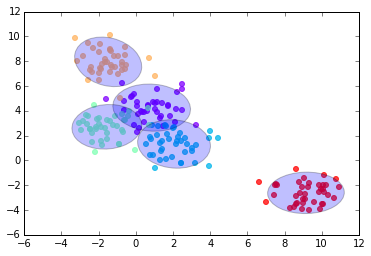

In [3]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

In [14]:
datasets = ['wine', 'iris', 'olivetti', 'vowel']
for dataset in datasets:
    for covdiag in [True,False]:
        print 'Output for dataset %s with covdiag=%s' % (dataset, covdiag)
        testClassifier(dataset=dataset, covdiag=covdiag)

Output for dataset wine with covdiag=True
Final mean classification accuracy  97.1509433962 with standard deviation 2.07538593305
Output for dataset wine with covdiag=False
Final mean classification accuracy  98.0566037736 with standard deviation 1.73861551496
Output for dataset iris with covdiag=True
Final mean classification accuracy  95.8222222222 with standard deviation 2.53917455237
Output for dataset iris with covdiag=False
Final mean classification accuracy  97.6444444444 with standard deviation 2.08036084239
Output for dataset olivetti with covdiag=True
Final mean classification accuracy  56.65 with standard deviation 4.07393476193
Output for dataset olivetti with covdiag=False
Final mean classification accuracy  55.4083333333 with standard deviation 4.43392070044
Output for dataset vowel with covdiag=True
Final mean classification accuracy  65.5909090909 with standard deviation 4.15533174601
Output for dataset vowel with covdiag=False
Final mean classification accuracy  90.538

/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


So, the results are for each dataset with the covdiag: 

Wine - **Covdiag**: 97.1 **!Covdiag**: 98.1 

Iris - **Covdiag**: 95.8 **!Covdiag**: 97.6 

Olivetti - **Covdiag**: 56.6 **!Covdiag**: 55.4 

Vowel - **Covdiag**: 65.6 **!Covdiag**: 90.5 

The independence assumption is reasonable for the wine, iris and olivetti, because the features do not have much to do with the source. For vowels, however, it is unreasonable to assume the features are independent from the source and from each other, as a vowel will impose a lot of restriction on the auditory features.

# Testing the mlParams for a uniform weight vector

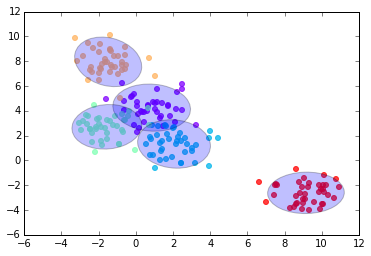

In [4]:
%matplotlib inline

X, labels = genBlobs(centers=5)
W = [1.0 / len(X)] * len(X)
mu, sigma = mlParams(X,labels,W)
plotGaussian(X,labels,mu,sigma)

As we can see the classification gives the same output as without weights, meaning the mlParams method is correctly implemented.

## Boosting functions to implement

The lab descriptions state what each function should do.

In [15]:
# in:       X - N x d matrix of N data points
#      labels - N x 1 vector of class labels
#           T - number of boosting iterations
# out: priors - length T list of prior as above
#         mus - length T list of mu as above
#      sigmas - length T list of sigma as above
#      alphas - T x 1 vector of vote weights 
def trainBoost(X,labels,T=5,covdiag=True):
    W = [1.0 / len(X)] * len(X)
    priors = []; mus = [];  sigmas = []; alphas = np.zeros((T))
    for i in range(0, T):
        priors.append(computePrior(labels,W))
        mu, sigma = mlParams(X, labels, W)
        mus.append(mu)
        sigmas.append(sigma)
        H = classify(X, priors[i], mus[i], sigmas[i], covdiag)
        all_zipped = zip(W, H, labels)
        error = sum([w for w, h, l in all_zipped if h != l])
        alpha = 0.5 * (np.log((1 - error) / (0.0001 if error == 0.0 else error)))
        for j in range(0, len(all_zipped)):
            weight_update = (np.exp(-alpha) if all_zipped[j][1] == all_zipped[j][2] else np.exp(alpha))
            W[j] = all_zipped[j][0] * weight_update
        alphas[i] = alpha
        W = np.true_divide(W, sum(W))
#     print alphas
    return priors, mus, sigmas, alphas

def classifyBoost(X,priors,mus,sigmas,alphas,covdiag=True):
    Npts = X.shape[0]
    Ncomps = len(mus)
    Nclasses = mus[0].shape[0]
    if Ncomps == 1:
        return classify(X,priors[0],mus[0],sigmas[0],covdiag=covdiag)
    else:    
        votes = np.zeros((Npts,Nclasses))
        ys = np.zeros((Npts,Ncomps))
        for icomp in range(0,Ncomps):
            # print mus[icomp].shape
            # print sigmas[icomp].shape
            # print alphas[icomp]
            ypred = classify(X,priors[icomp],mus[icomp],sigmas[icomp],covdiag=covdiag).astype(int)
            for i in range(0,Npts):
                votes[i,ypred[i]] += alphas[icomp]
        return np.argmax(votes,axis=1)


# Testing our boosting function

In [14]:
datasets = ['iris', 'wine', 'olivetti', 'vowel']
for dataset in datasets:
    for covdiag in [True, False]:
        print 'Output for dataset %s with covdiag=%s' % (dataset, covdiag)
        testClassifier(dataset=dataset, covdiag=covdiag, doboost=True)

Output for dataset iris with covdiag=True
Final mean classification accuracy  93.7555555556 with standard deviation 4.16564431902
Output for dataset iris with covdiag=False
Final mean classification accuracy  91.7111111111 with standard deviation 4.53088169001
Output for dataset wine with covdiag=True
Final mean classification accuracy  87.3773584906 with standard deviation 12.881957158
Output for dataset wine with covdiag=False
Final mean classification accuracy  95.6226415094 with standard deviation 3.81001285237
Output for dataset olivetti with covdiag=True
Final mean classification accuracy  56.4333333333 with standard deviation 4.46604473282
Output for dataset olivetti with covdiag=False
Final mean classification accuracy  56.2166666667 with standard deviation 4.80367336294
Output for dataset vowel with covdiag=True
Final mean classification accuracy  68.0194805195 with standard deviation 4.70353591742
Output for dataset vowel with covdiag=False
Final mean classification accuracy 

/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
np.set_printoptions(threshold=np.nan)
np.set_printoptions(precision=25)
np.set_printoptions(linewidth=200)

def testClassifier(dataset='iris',dim=0,split=0.7,doboost=False,boostiter=5,covdiag=True,ntrials=100):

    X,y,pcadim = fetchDataset(dataset)

    means = np.zeros(ntrials,);

    for trial in range(ntrials):

        # xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplit(X,y,split)
        xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split)

        # Do PCA replace default value if user provides it 
        if dim > 0:
            pcadim = dim
        if pcadim > 0:     
            pca = decomposition.PCA(n_components=pcadim)
            pca.fit(xTr)
            xTr = pca.transform(xTr)
            xTe = pca.transform(xTe)     

        ## Boosting  
        if doboost:
            # Compute params
            priors,mus,sigmas,alphas = trainBoost(xTr,yTr,T=boostiter,covdiag=covdiag)
            yPr = classifyBoost(xTe,priors,mus,sigmas,alphas)        
        else:
        ## Simple
            # Compute params
            prior = computePrior(yTr)
            mu, sigma = mlParams(xTr,yTr)
            # Predict
            yPr = classify(xTe,prior,mu,sigma,covdiag=covdiag)

        # Compute classification error
#         print "Trial:",trial,"Accuracy",100*np.mean((yPr==yTe).astype(float))

        means[trial] = 100*np.mean((yPr==yTe).astype(float))

    print "Final mean classification accuracy ", np.mean(means), "with standard deviation", np.std(means)


## Plotting the decision boundary

This is some code that you can use for plotting the decision boundary
boundary in the last part of the lab.

In [8]:
def plotBoundary(dataset='iris',split=0.7,doboost=False,boostiter=5,covdiag=True):
    
    X,y,pcadim = fetchDataset(dataset)
    xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split)
    pca = decomposition.PCA(n_components=2)
    pca.fit(xTr)
    xTr = pca.transform(xTr)
    xTe = pca.transform(xTe)
    
    pX = np.vstack((xTr, xTe))
    py = np.hstack((yTr, yTe))
     
    if doboost:
        ## Boosting
        # Compute params
        priors,mus,sigmas,alphas = trainBoost(xTr,yTr,T=boostiter,covdiag=covdiag)       
    else:
        ## Simple
        # Compute params
        prior = computePrior(yTr)
        mu, sigma = mlParams(xTr,yTr)

    xRange = np.arange(np.min(pX[:,0]),np.max(pX[:,0]),np.abs(np.max(pX[:,0])-np.min(pX[:,0]))/100.0)
    yRange = np.arange(np.min(pX[:,1]),np.max(pX[:,1]),np.abs(np.max(pX[:,1])-np.min(pX[:,1]))/100.0)

    grid = np.zeros((yRange.size, xRange.size))
    
    for (xi, xx) in enumerate(xRange):
        for (yi, yy) in enumerate(yRange):
            if doboost:
                ## Boosting 
                grid[yi,xi] = classifyBoost(np.matrix([[xx, yy]]),priors,mus,sigmas,alphas,covdiag=covdiag)        
            else:
                ## Simple
                grid[yi,xi] = classify(np.matrix([[xx, yy]]),prior,mu,sigma,covdiag=covdiag)
    
    classes = range(np.min(y), np.max(y)+1)
    ys = [i+xx+(i*xx)**2 for i in range(len(classes))]
    colormap = cm.rainbow(np.linspace(0, 1, len(ys)))

    plt.hold(True)
    conv = ColorConverter()
    for (color, c) in zip(colormap, classes):
        try:
            CS = plt.contour(xRange,yRange,(grid==c).astype(float),15,linewidths=0.25,colors=conv.to_rgba_array(color))
        except ValueError:
            pass
        xc = pX[py == c, :]
        plt.scatter(xc[:,0],xc[:,1],marker='o',c=color,s=40,alpha=0.5)
        
    plt.xlim(np.min(pX[:,0]),np.max(pX[:,0]))
    plt.ylim(np.min(pX[:,1]),np.max(pX[:,1]))
    plt.show()

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

Dataset iris without boost and covdiag True


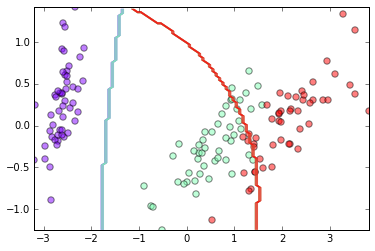

Dataset iris with boost and covdiag True


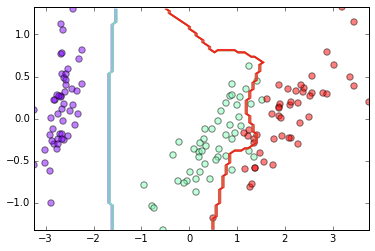

Dataset wine without boost and covdiag True


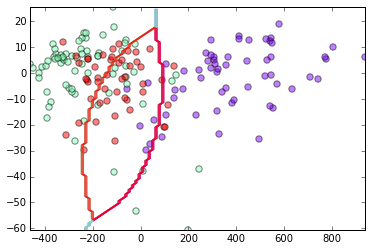

Dataset wine with boost and covdiag True


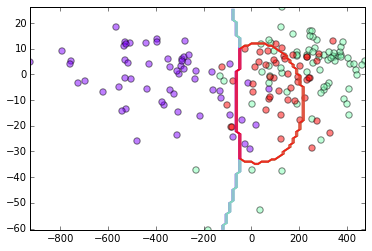

Dataset olivetti without boost and covdiag True


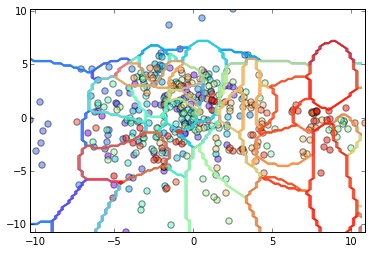

Dataset olivetti with boost and covdiag True


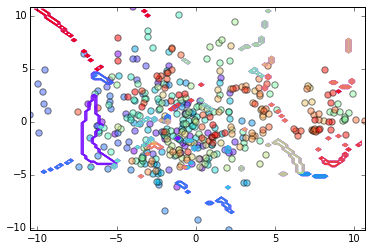

Dataset vowel without boost and covdiag True


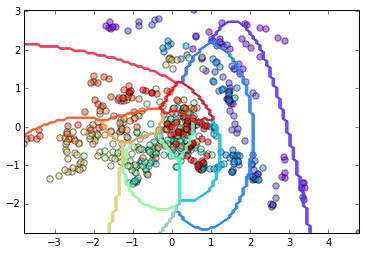

Dataset vowel with boost and covdiag True


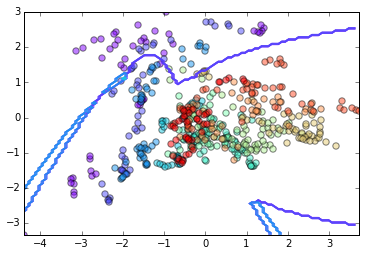

Dataset iris without boost and covdiag False


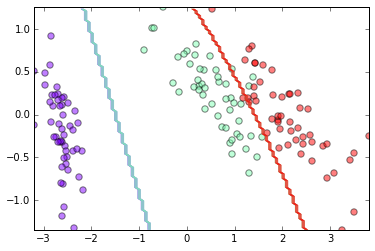

Dataset iris with boost and covdiag False


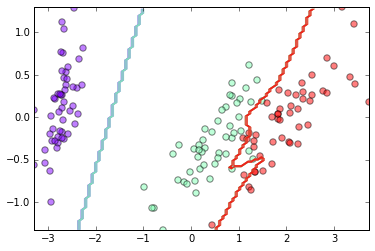

Dataset wine without boost and covdiag False


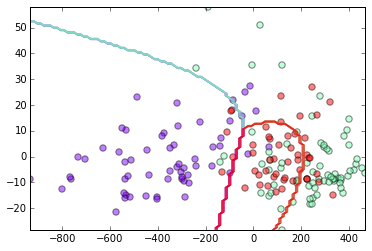

Dataset wine with boost and covdiag False


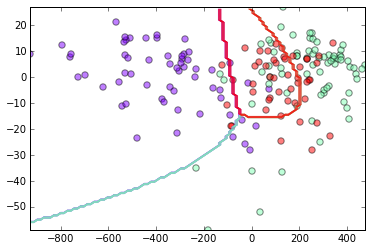

Dataset olivetti without boost and covdiag False


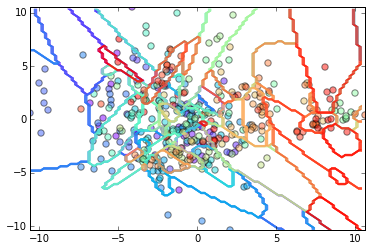

Dataset olivetti with boost and covdiag False


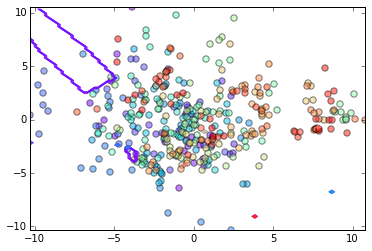

Dataset vowel without boost and covdiag False


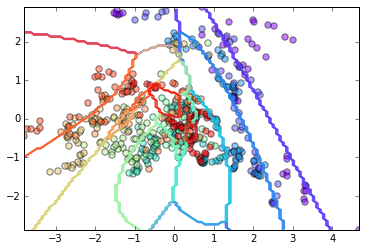

Dataset vowel with boost and covdiag False


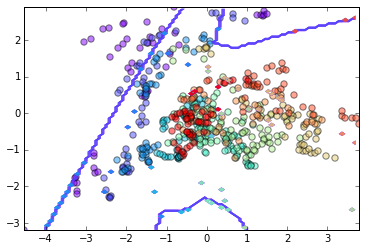

In [22]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Example usage of the functions

datasets = ['iris', 'wine', 'olivetti', 'vowel']

for covdiag in [True, False]:
    for dataset in datasets:
        print 'Dataset %s without boost and covdiag %s' % (dataset, covdiag)
        plotBoundary(dataset=dataset,covdiag=covdiag, doboost=False)
        print 'Dataset %s with boost and covdiag %s' % (dataset, covdiag)
        plotBoundary(dataset=dataset,covdiag=covdiag, doboost=True)